<a href="https://colab.research.google.com/github/Himakar06/Employee_Attrition/blob/main/notebooks/Employee_Attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings


from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [71]:
df = pd.read_csv('Employee_Data.csv')
df.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,12/31/2006 0:00,1/3/1954,8/28/1989,1/1/1900,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1,1318,12/31/2007 0:00,1/3/1954,8/28/1989,1/1/1900,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
2,1318,12/31/2008 0:00,1/3/1954,8/28/1989,1/1/1900,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
3,1318,12/31/2009 0:00,1/3/1954,8/28/1989,1/1/1900,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE
4,1318,12/31/2010 0:00,1/3/1954,8/28/1989,1/1/1900,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE


In [6]:
print("shape :",df.shape)
print("Duplicate values : ",df.duplicated().any())

shape : (49653, 18)
Duplicate values :  False


In [7]:
df.isnull().sum()

,0
EmployeeID,0
recorddate_key,0
birthdate_key,0
orighiredate_key,0
terminationdate_key,0
age,0
length_of_service,0
city_name,0
department_name,0
job_title,0


In [8]:
df.drop(['EmployeeID', 'birthdate_key', 'recorddate_key', 'gender_full'], axis=1, inplace=True)

In [10]:
df.head()

,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,8/28/1989,1/1/1900,52,17,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1,8/28/1989,1/1/1900,53,18,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
2,8/28/1989,1/1/1900,54,19,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
3,8/28/1989,1/1/1900,55,20,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE
4,8/28/1989,1/1/1900,56,21,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE


In [11]:
df.city_name.unique()

array(['Vancouver', 'Terrace', 'Nanaimo', 'Nelson', 'Kelowna', 'Victoria',
       'Kamloops', 'Fort St John', 'Surrey', 'Vernon', 'Quesnel',
       'Chilliwack', 'Dawson Creek', 'Squamish', 'New Westminster',
       'Port Coquitlam', 'Cortes Island', 'Burnaby', 'Bella Bella',
       'Cranbrook', 'Williams Lake', 'Trail', 'Prince George', 'Richmond',
       'Grand Forks', 'West Vancouver', 'Abbotsford', 'Aldergrove',
       'Langley', 'North Vancouver', 'White Rock', 'New Westminister',
       'Fort Nelson', 'Haney', 'Valemount', 'Ocean Falls', 'Princeton',
       'Dease Lake', 'Pitt Meadows', 'Blue River'], dtype=object)

In [12]:
df.job_title.unique()

array(['CEO', 'VP Stores', 'Legal Counsel', 'VP Human Resources',
       'VP Finance', 'Exec Assistant, VP Stores',
       'Exec Assistant, Legal Counsel', 'CHief Information Officer',
       'Store Manager', 'Meats Manager',
       'Exec Assistant, Human Resources', 'Exec Assistant, Finance',
       'Director, Recruitment', 'Director, Training',
       'Director, Labor Relations', 'Director, HR Technology',
       'Director, Employee Records', 'Director, Compensation',
       'Corporate Lawyer', 'Produce Manager',
       'Director, Accounts Receivable', 'Bakery Manager',
       'Systems Analyst', 'Director, Accounts Payable', 'Director, Audit',
       'Director, Accounting', 'Director, Investments', 'Dairy Person',
       'Recruiter', 'Processed Foods Manager', 'Customer Service Manager',
       'Trainer', 'Meat Cutter', 'Labor Relations Analyst',
       'Dairy Manager', 'HRIS Analyst', 'Benefits Admin',
       'Compensation Analyst', 'Accounts Receiveable Clerk',
       'Accounts Pay

In [14]:
#Converting Job Titles into four Categories
board = ['CEO','VP Stores', 'Director, Recruitment', 'VP Human Resources', 'VP Finance', 'Director, Accounts Receivable',
         'Director, Accounting', 'Director, Employee Records', 'Director, Accounts Payable', 'Director, HR Technology',
         'Director, Investments', 'Director, Labor Relations', 'Director, Audit', 'Director, Training',
         'Director, Compensation']

executive = [ 'Exec Assistant, VP Stores', 'Exec Assistant, Legal Counsel', 'CHief Information Officer',
             'Exec Assistant, Human Resources', 'Exec Assistant, Finance']

manager = ['Customer Service Manager', 'Processed Foods Manager', 'Meats Manager',
           'Bakery Manager', 'Produce Manager', 'Store Manager', 'Trainer', 'Dairy Manager']
employee = ['Meat Cutter', 'Dairy Person', 'Produce Clerk', 'Baker', 'Cashier',
            'Shelf Stocker', 'Recruiter', 'HRIS Analyst', 'Accounting Clerk',
            'Benefits Admin', 'Labor Relations Analyst', 'Accounts Receiveable Clerk',
            'Accounts Payable Clerk', 'Auditor', 'Compensation Analyst',
            'Investment Analyst', 'Systems Analyst', 'Corporate Lawyer', 'Legal Counsel']

def job_title(job):
    if job in board: return 'board'
    if job in executive: return 'executive'
    if job in manager: return 'manager'
    if job in employee: return 'employee'

df['job_title'] = df['job_title'].map(job_title)


In [16]:
df.job_title.unique()

array(['board', 'employee', 'executive', 'manager'], dtype=object)

In [19]:
#Changing the City Names
city_population = {
    'Vancouver':2313328,
     'Victoria':289625,
     'Nanaimo':84905,
     'New Westminster':58549,
     'Kelowna':125109,
     'Burnaby':202799,
     'Kamloops':68714,
     'Prince George':65558,
     'Cranbrook':18610,
     'Surrey':394976,
     'Richmond':182000,
     'Terrace':19443,
     'Chilliwack':77000,
     'Trail':9707,
     'Langley':23606,
     'Vernon':47274,
     'Squamish':19512,
     'Quesnel':13799,
     'Abbotsford':151683,
     'North Vancouver':48000,
     'Fort St John':17402,
     'Williams Lake':14168,
     'West Vancouver':42694,
     'Port Coquitlam':114565,
     'Aldergrove':12363,
     'Fort Nelson':3561,
     'Nelson':9813,
     'New Westminister':58549,
     'Grand Forks':4049,
     'White Rock':66450,
     'Haney':82256,
     'Princeton':2828,
     'Dawson Creek':10802,
     'Bella Bella':1019,
     'Ocean Falls':129,
     'Pitt Meadows':174410,
     'Cortes Island':1042,
     'Valemount':1021,
     'Dease Lake':335,
     'Blue River':157
}

def change_city_into_city_pop(city):
    return city_population(city)

df['city_name'] = df['city_name'].map(city_population)

In [20]:
#Converting cities to either "Rural" or "Town"

def change_city(population):
    str = 'rural'
    if (population >= 10000) & (population < 100000): str = 'town'
    if population >= 100000: str = 'mega'
    return str

df['city_name'] = df.city_name.map(change_city)

In [21]:
#Distribution of Status

df.STATUS.value_counts()

,count
STATUS,
ACTIVE,48168
TERMINATED,1485


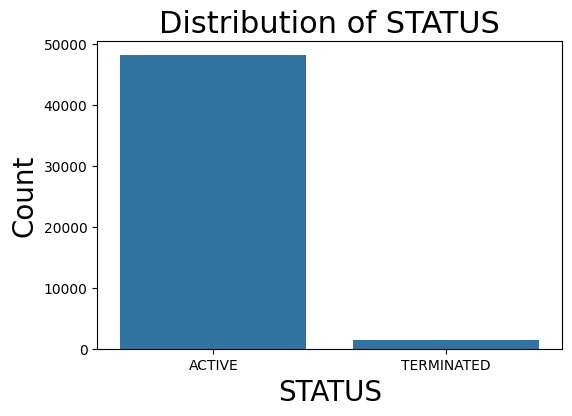

In [27]:
status_label = df.STATUS.value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=status_label.index, y=status_label.values)
plt.xlabel('STATUS', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Distribution of STATUS', fontsize=22)
plt.show()


In [29]:
from sklearn.utils import resample

# Separate Target Classes
df_1 = df[df.STATUS=="ACTIVE"]
df_2 = df[df.STATUS=="TERMINATED"]

# Upsample minority class
df_2_upsampled = resample(df_2,
                                 replace=True,     # sample with replacement
                                 n_samples=48168,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_1, df_2_upsampled])

# Display new class counts
df_upsampled.STATUS.value_counts()

,count
STATUS,
ACTIVE,48168
TERMINATED,48168


Text(0, 0.5, 'Count')

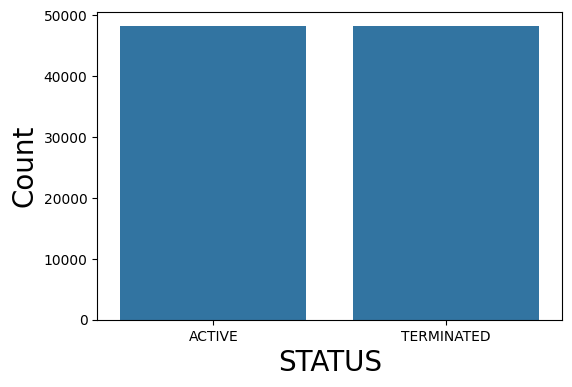

In [32]:
status_label = df_upsampled.STATUS.value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=status_label.index,y= status_label);
plt.xlabel('STATUS', fontsize=20);
plt.ylabel('Count', fontsize=20)

<Axes: xlabel='BUSINESS_UNIT', ylabel='count'>

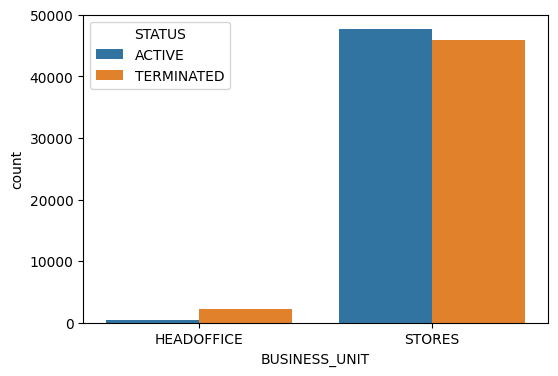

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x="BUSINESS_UNIT", hue="STATUS", data=df_upsampled)

/tmp/ipython-input-36-2219914138.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_upsampled[column], color = '#32384D', label = 'terminated',  kde = True)
/tmp/ipython-input-36-2219914138.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_upsampled[column], color = '#32384D', label = '

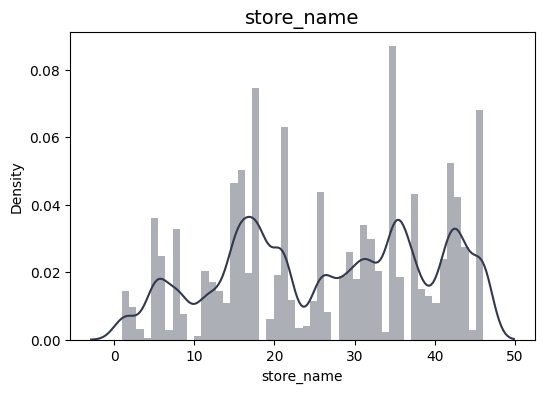

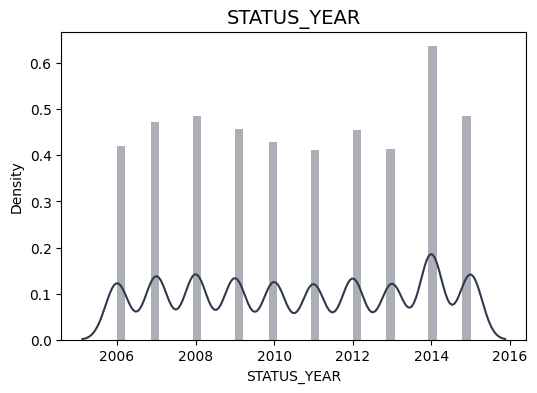

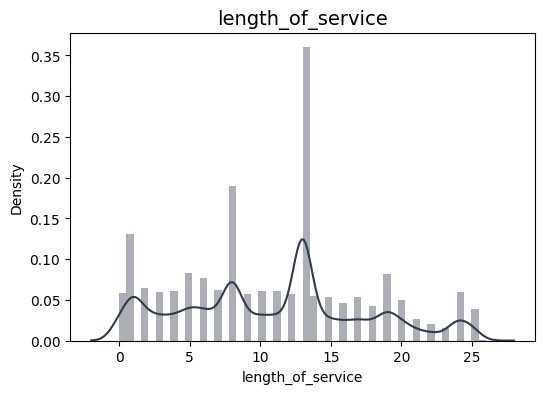

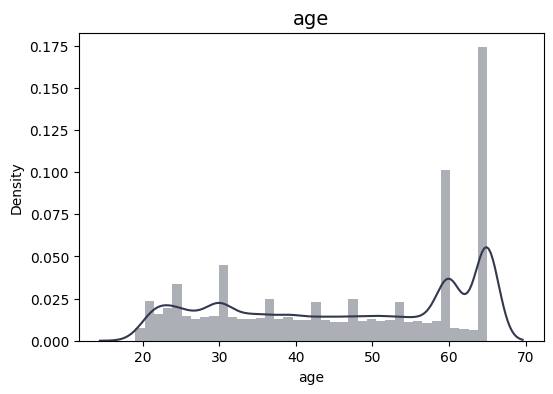

In [36]:
for column in ['store_name', 'STATUS_YEAR', 'length_of_service', 'age']:
    plt.figure(figsize=(6,4))
    sns.distplot(df_upsampled[column], color = '#32384D', label = 'terminated',  kde = True)
    plt.title(column, size = 14)

In [37]:
#City Name

city_name_label = {value: key for key, value in enumerate(df_upsampled['city_name'].unique())}
df_upsampled['city_name'] = df_upsampled['city_name'].map(city_name_label)

In [38]:
department_name_label = {value: key for key, value in enumerate(df_upsampled['department_name'].unique())}
df_upsampled['department_name'] = df_upsampled['department_name'].map(department_name_label)

In [39]:
job_title_label = {value: key for key, value in enumerate(df_upsampled['job_title'].unique())}
df_upsampled['job_title'] = df_upsampled['job_title'].map(job_title_label)

In [40]:
gender_short_label = {value: key for key, value in enumerate(df_upsampled['gender_short'].unique())}
df_upsampled['gender_short'] = df_upsampled['gender_short'].map(gender_short_label)

In [41]:
#Reason for Termination

term_desc_label = {value: key for key, value in enumerate(df_upsampled['termreason_desc'].unique())}
df_upsampled['termreason_desc'] = df_upsampled['termreason_desc'].map(term_desc_label)


In [42]:
#Type of Termination

termtype_desc_label = {value: key for key, value in enumerate(df_upsampled['termtype_desc'].unique())}
df_upsampled['termtype_desc'] = df_upsampled['termtype_desc'].map(termtype_desc_label)

In [43]:
#Status

status_label = {value: key for key, value in enumerate(df_upsampled['STATUS'].unique())}
df_upsampled['STATUS'] = df_upsampled['STATUS'].map(status_label)

In [44]:
#Business Unit

business_label = {value: key for key, value in enumerate(df_upsampled['BUSINESS_UNIT'].unique())}
df_upsampled['BUSINESS_UNIT'] = df_upsampled['BUSINESS_UNIT'].map(business_label)

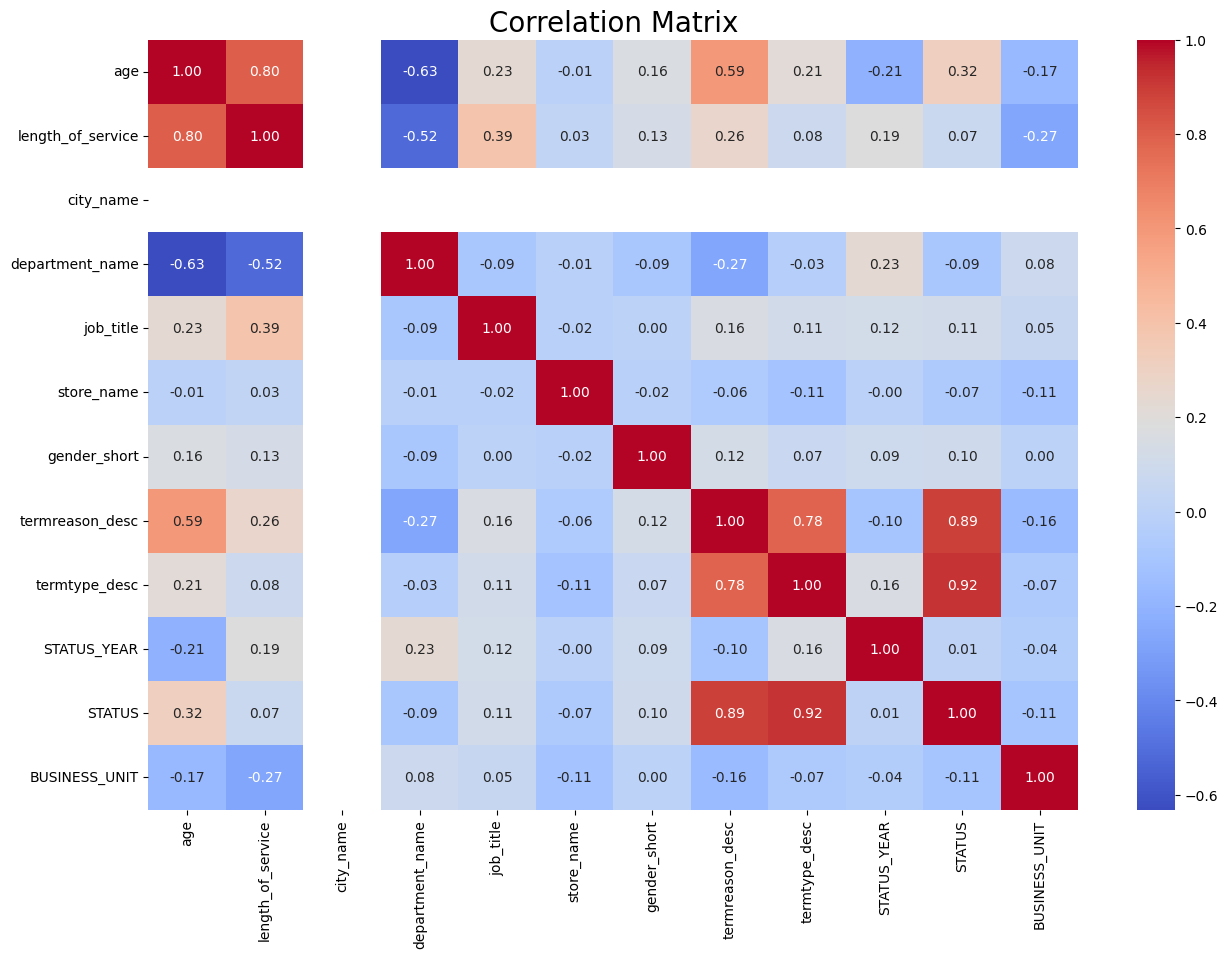

In [46]:
plt.figure(figsize=(15, 10))
numeric_df = df_upsampled.select_dtypes(include=['number'])  # Only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=20)
plt.show()


In [47]:
#Dropping more unimportant columns

df_upsampled.drop(['termreason_desc', 'termtype_desc', 'orighiredate_key', 'terminationdate_key'], axis=1, inplace=True)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc

In [49]:
accuracy_list = []
f1_list = []
roc_auc_list = []

In [54]:
#Train Test Evaluation Function

def result(X, y, ts, rs, model):

    #train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)

    #scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    #fit on data
    model.fit(X_train, y_train)

    #prediction
    pred = model.predict(X_test)

    #performance of model
    print("Classification Report: \n", classification_report(y_test, pred))
    print("-" * 100)
    print()

    #accuracy of model
    acc = accuracy_score(y_test, pred)
    accuracy_list.append(acc)
    print("Accuracy Score: ", acc)
    print("-" * 100)
    print()

    #f1-score of model
    f1 = f1_score(y_test, pred)
    f1_list.append(f1)
    print("F1 Score: ", f1)
    print("-" * 100)
    print()
     #roc-auc curve of model
    fpr,tpr,threshold = roc_curve(y_test,pred)
    auc_value = auc(fpr,tpr)
    rocauc_score = roc_auc_score(y_test, pred)
    roc_auc_list.append(rocauc_score)
    plt.figure(figsize=(5,5),dpi=100)
    print("ROC-AUC Score: ", f1)
    print("-" * 100)
    print()
    plt.plot(fpr,tpr,linestyle='-',label = "(auc_value = %0.3f)" % auc_value)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print()

    #confusion matrix for model
    print("Confusion Matrix: ")
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='g');
    plt.title('Confusion Matrix', fontsize=20)

In [55]:
#Independent and Dependent Features

x = df_upsampled[['age', 'length_of_service', 'city_name', 'department_name', 'job_title', 'store_name', 'gender_short',
       'STATUS_YEAR', 'BUSINESS_UNIT']]
y = df_upsampled[['STATUS']]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.86      0.80     12067
           1       0.83      0.72      0.77     12017

    accuracy                           0.79     24084
   macro avg       0.79      0.79      0.79     24084
weighted avg       0.79      0.79      0.79     24084

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.7877428998505231
----------------------------------------------------------------------------------------------------

F1 Score:  0.7710908113917249
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.7710908113917249
----------------------------------------------------------------------------------------------------



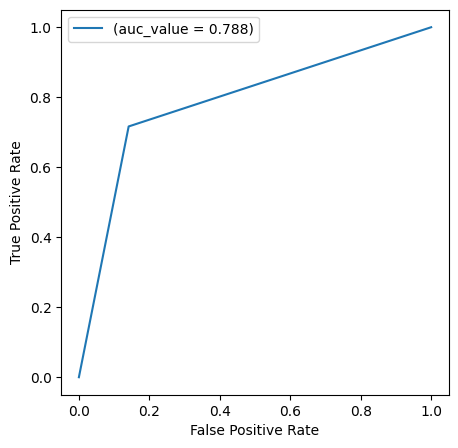


Confusion Matrix: 


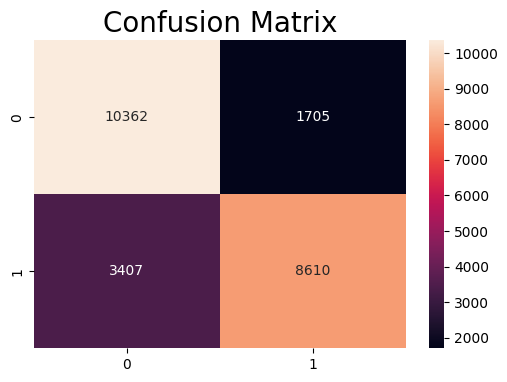

In [56]:
#Logistic Regression

model = LogisticRegression()
result(x, y, 0.25, 42, model)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     12067
           1       0.98      1.00      0.99     12017

    accuracy                           0.99     24084
   macro avg       0.99      0.99      0.99     24084
weighted avg       0.99      0.99      0.99     24084

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9905331340308918
----------------------------------------------------------------------------------------------------

F1 Score:  0.990602588409859
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.990602588409859
----------------------------------------------------------------------------------------------------



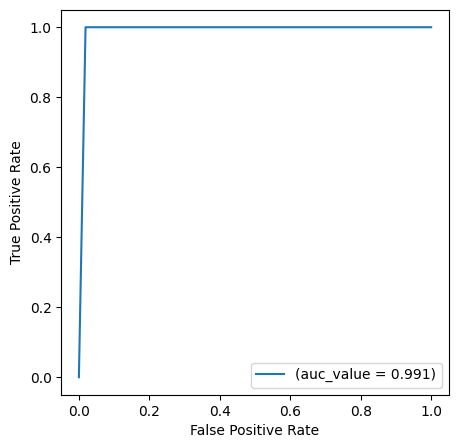


Confusion Matrix: 
Feature ranking:
1. age (importance: 0.43330527150171533)
2. store_name (importance: 0.18455475922162967)
3. length_of_service (importance: 0.1319998918058467)
4. STATUS_YEAR (importance: 0.12961833121811644)
5. department_name (importance: 0.06652126567959184)
6. gender_short (importance: 0.04374393835621542)
7. job_title (importance: 0.00865717505957991)
8. BUSINESS_UNIT (importance: 0.001599367157304649)
9. city_name (importance: 0.0)


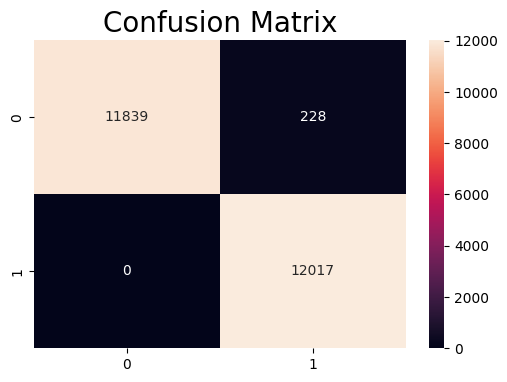

In [57]:
#Random Forest Classifier

rf = RandomForestClassifier()
result(x, y, 0.25, 42, rf)

# Get the feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Print the feature rankings with feature names
print("Feature ranking:")

for f in range(x.shape[1]):
    print(f"{f + 1}. {x.columns[indices[f]]} (importance: {importances[indices[f]]})")

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     12067
           1       0.95      1.00      0.97     12017

    accuracy                           0.97     24084
   macro avg       0.97      0.97      0.97     24084
weighted avg       0.97      0.97      0.97     24084

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9735924265072247
----------------------------------------------------------------------------------------------------

F1 Score:  0.97412109375
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.97412109375
----------------------------------------------------------------------------------------------------



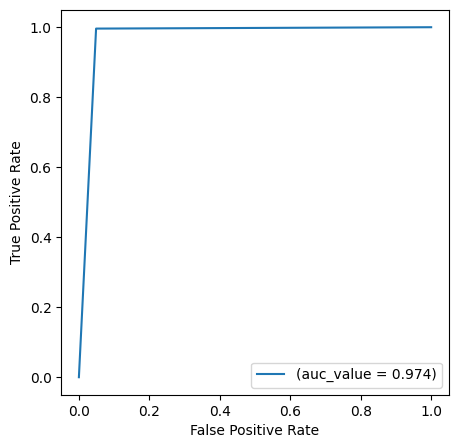


Confusion Matrix: 


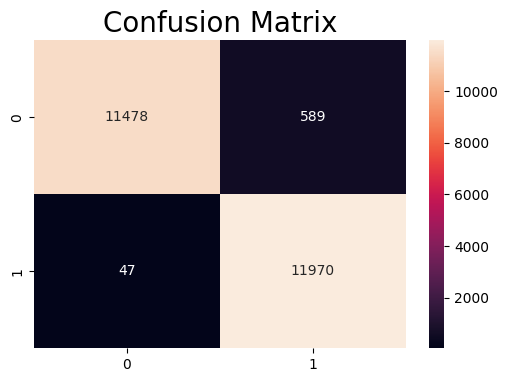

In [60]:
#KNN Classifier

knn = KNeighborsClassifier()
result(x, y, 0.25, 42, knn)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.96      0.91     12067
           1       0.96      0.85      0.90     12017

    accuracy                           0.91     24084
   macro avg       0.91      0.91      0.91     24084
weighted avg       0.91      0.91      0.91     24084

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9059541604384653
----------------------------------------------------------------------------------------------------

F1 Score:  0.9000044148161229
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.9000044148161229
----------------------------------------------------------------------------------------------------



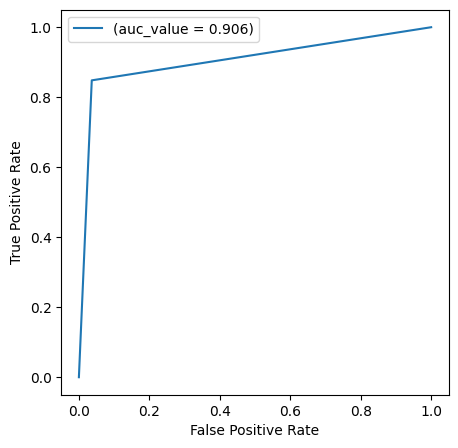


Confusion Matrix: 


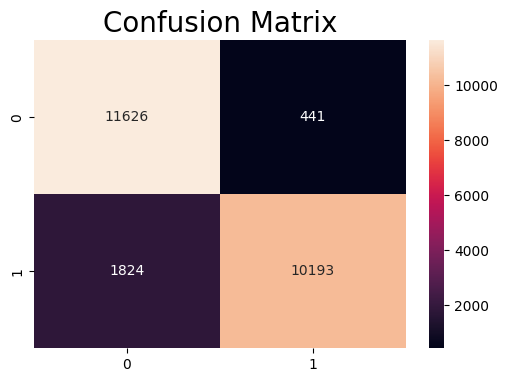

In [62]:
#Gradient Boosting Classifier

gb = GradientBoostingClassifier()
result(x, y, 0.25, 42, gb)

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     12067
           1       0.98      0.97      0.97     12017

    accuracy                           0.97     24084
   macro avg       0.97      0.97      0.97     24084
weighted avg       0.97      0.97      0.97     24084

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9740076399269224
----------------------------------------------------------------------------------------------------

F1 Score:  0.9738643954575819
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.9738643954575819
----------------------------------------------------------------------------------------------------



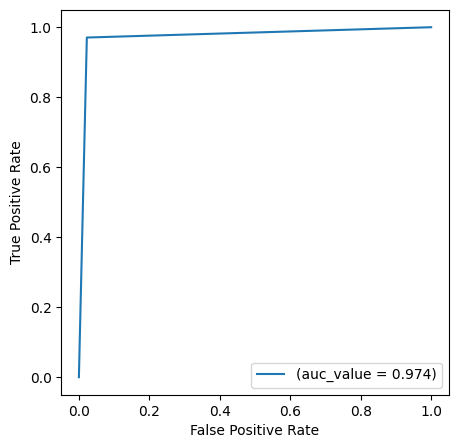


Confusion Matrix: 


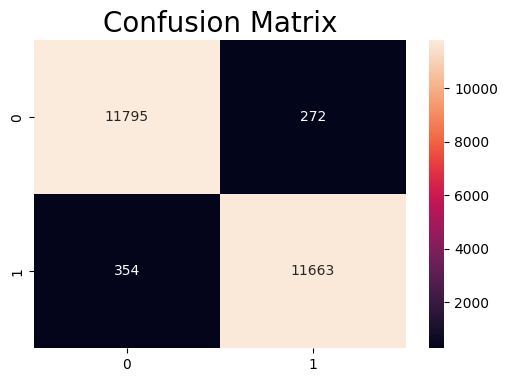

In [63]:
xg = xgb.XGBClassifier()
result(x, y, 0.25, 42, xg)

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     12067
           1       0.98      1.00      0.99     12017

    accuracy                           0.99     24084
   macro avg       0.99      0.99      0.99     24084
weighted avg       0.99      0.99      0.99     24084

----------------------------------------------------------------------------------------------------

Accuracy Score:  0.9892459724298289
----------------------------------------------------------------------------------------------------

F1 Score:  0.989338492569876
----------------------------------------------------------------------------------------------------

ROC-AUC Score:  0.989338492569876
----------------------------------------------------------------------------------------------------



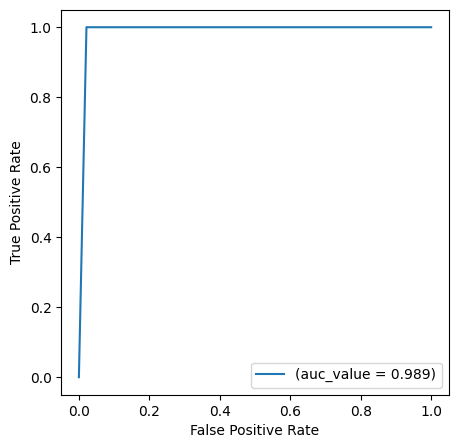


Confusion Matrix: 


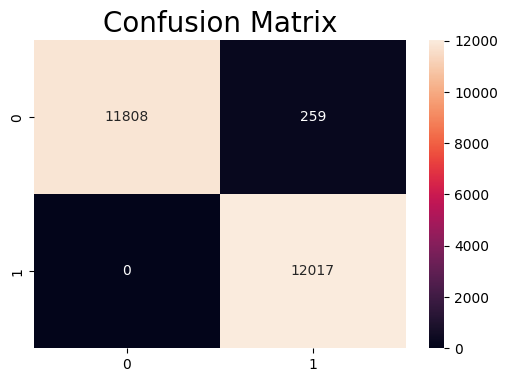

In [64]:
#Decision Tree Classifier

dt = DecisionTreeClassifier()
result(x, y, 0.25, 42, dt)

In [67]:
#Classifier Comparison
classifier_list = ["Logistic Regression", "Random Forest", "KNN", "Gradient Boosting", "XGBoost",  "Decision Tree"]
list_class = []
for i in range(0, len(classifier_list)):
  listclass = [classifier_list[i], accuracy_list[i], f1_list[i], roc_auc_list[i]]
  list_class.append(listclass)

list_class

[['Logistic Regression',
  0.7877428998505231,
  0.7710908113917249,
  np.float64(0.7875952701160442)],
 ['Random Forest',
  0.7877428998505231,
  0.7710908113917249,
  np.float64(0.7875952701160442)],
 ['KNN',
  0.9905331340308918,
  0.990602588409859,
  np.float64(0.9905527471616806)],
 ['Gradient Boosting',
  0.9735924265072247,
  0.97412109375,
  np.float64(0.9736390338818575)],
 ['XGBoost',
  0.9735924265072247,
  0.97412109375,
  np.float64(0.9736390338818575)],
 ['Decision Tree',
  0.9059541604384653,
  0.9000044148161229,
  np.float64(0.9058345384700202)]]

In [68]:
cc_table = pd.DataFrame(list_class, columns = ["Classifier", "Accuracy", "F1 Score", "ROC-AUC Score"])
cc_table.sort_values(ascending = False, by = "Accuracy")

,Classifier,Accuracy,F1 Score,ROC-AUC Score
2,KNN,0.990533,0.990603,0.990553
3,Gradient Boosting,0.973592,0.974121,0.973639
4,XGBoost,0.973592,0.974121,0.973639
5,Decision Tree,0.905954,0.900004,0.905835
1,Random Forest,0.787743,0.771091,0.787595
0,Logistic Regression,0.787743,0.771091,0.787595


<Axes: xlabel='Accuracy', ylabel='Classifier'>

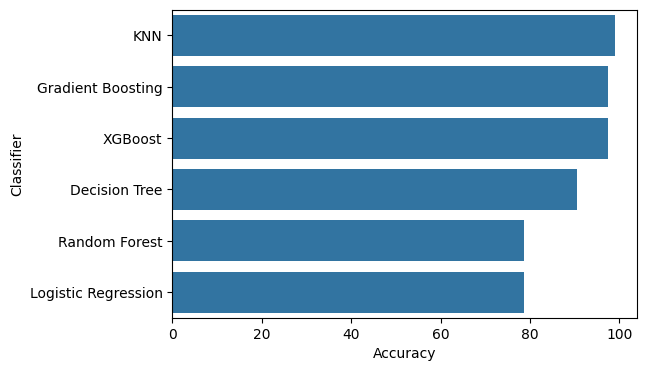

In [70]:
#For Accuracy

plt.figure(figsize = (6,4))
sns.barplot(x = cc_table["Accuracy"]*100,
            y = cc_table["Classifier"],
            data = cc_table,
            order = cc_table.sort_values("Accuracy", ascending = False).Classifier)

In [ ]:
#Compare models and select best performer
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    acc = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy').mean()
    f1 = cross_val_score(pipeline, X, y, cv=skf, scoring='f1').mean()
    roc = cross_val_score(pipeline, X, y, cv=skf, scoring='roc_auc').mean()

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'F1 Score': round(f1, 4),
        'ROC AUC': round(roc, 4)
    })

results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print(results_df)

                 Model  Accuracy  F1 Score  ROC AUC
0  Logistic Regression    0.7565    0.4872   0.8179
2    Gradient Boosting    0.8667    0.4716   0.8056
3                  SVM    0.8374    0.4594   0.7772
5              XGBoost    0.8585    0.4477   0.8053
1        Random Forest    0.8619    0.3972   0.8077
4                  KNN    0.6320    0.3603   0.6789


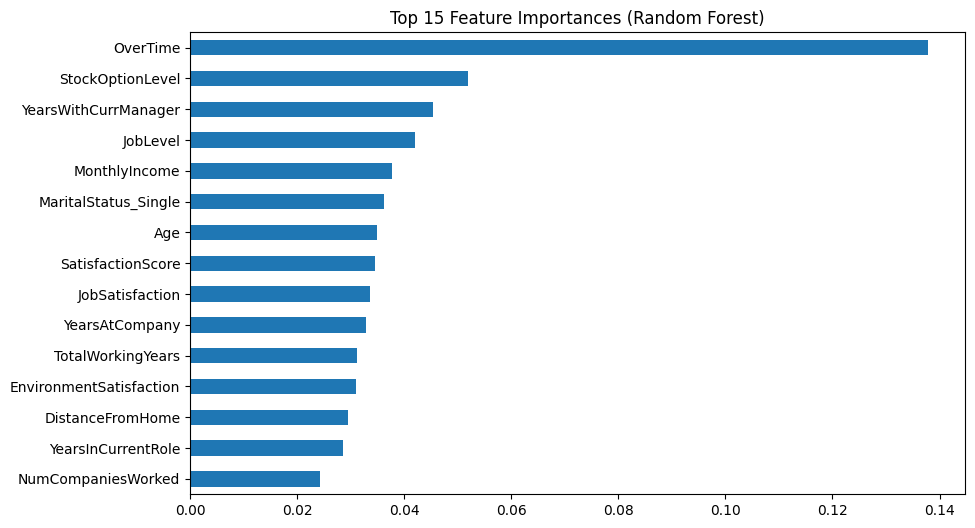

In [ ]:
# Train best model (example: Random Forest here)
best_model_name = 'Random Forest'
best_model = models[best_model_name]

# Fit pipeline manually on entire data
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_model)
])

pipeline.fit(X, y)

# Get feature names after preprocessing (assume no column changes after scaling/SMOTE)
feature_names = X.columns

# Extract feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = pipeline.named_steps['classifier'].feature_importances_
    importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)
elif hasattr(best_model, 'coef_'):
    importances = pipeline.named_steps['classifier'].coef_[0]
    importance_df = pd.Series(importances, index=feature_names).sort_values(key=abs, ascending=False)
else:
    print("Model does not support feature importances.")
    importance_df = None

# Plot
if importance_df is not None:
    plt.figure(figsize=(10, 6))
    importance_df.head(15).plot(kind='barh')
    plt.title(f"Top 15 Feature Importances ({best_model_name})")
    plt.gca().invert_yaxis()
    plt.show()


 Hold-Out Test Set Evaluation:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

📄 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       1.00      1.00      1.00        47

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294



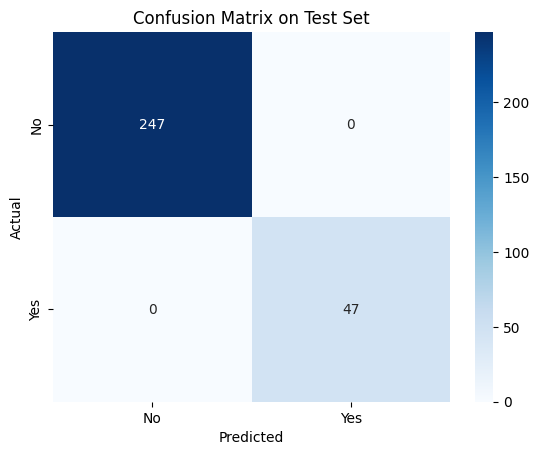

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # For ROC AUC


print(" Hold-Out Test Set Evaluation:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()


In [ ]:
import joblib
joblib.dump(pipeline, "employee_attrition_model.csv")


['employee_attrition_model.csv']